In [57]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
from pyiem.meteorology import uv
from pyiem.util import get_dbconn
from pyiem.datatypes import speed, direction

In [1]:
PGCONN = get_dbconn("mec", user="mesonet")
cursor = PGCONN.cursor()

cursor.execute("""
  SELECT one.valid, one.yaw, two.yaw from sampled_data_1 one JOIN sampled_data_11 two 
  on (one.valid = two.valid) WHERE one.yaw is not null and two.yaw is not null
  and extract(minute from one.valid) = 0
""")
yaw1 = []
yaw2 = []
for row in cursor:
    yaw1.append( row[1] )
    yaw2.append( row[2] )
    

NameError: name 'get_dbconn' is not defined

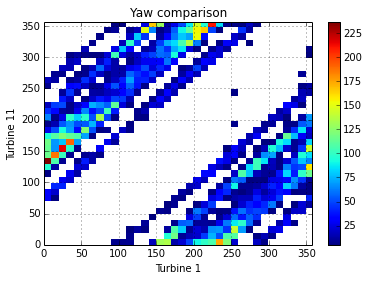

In [23]:
(fig, ax) = plt.subplots(1,1)

yaw1 = np.array(yaw1)
yaw2 = np.array(yaw2)
ar = ax.hist2d(yaw1, yaw2, bins=36, cmin=5)
fig.colorbar(ar[3])
ax.set_xlabel("Turbine 1")
ax.set_ylabel("Turbine 11")
ax.set_title("Yaw frequency comparison")
ax.grid(True)

In [25]:
PGCONN = psycopg2.connect("dbname=mec host=localhost port=5555 user=mesonet")
cursor = PGCONN.cursor()
PGCONN2 = psycopg2.connect("dbname=asos host=localhost port=5555 user=mesonet")
acursor = PGCONN2.cursor()

# Go find interesting cases!
acursor.execute("""
  SELECT valid, drct from t2010 where station = 'SLB'
  and extract(hour from valid) between 8 and 16 and sknt > 15
  """)
asos = []
turbine = []
for row in acursor:
    cursor.execute("""SELECT yaw from sampled_data_11 where valid = %s""", (row[0],))
    if cursor.rowcount == 0:
        continue
    row2 = cursor.fetchone()
    asos.append( row[1] )
    turbine.append( row2[0] )

5487


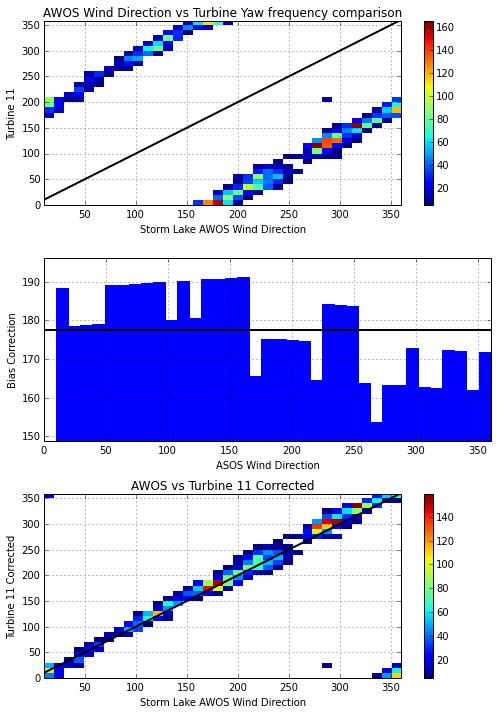

In [55]:
(fig, ax) = plt.subplots(3,1, figsize=(7,10))

(counts, xedges, yedges, img) = ax[0].hist2d(asos, turbine, bins=36, cmin=5)
fig.colorbar(img, ax=ax[0])
ax[0].set_xlabel("Storm Lake AWOS Wind Direction")
ax[0].set_ylabel("Turbine 11")
ax[0].plot([0,360], [0,360], lw=2, zorder=2, color='k')
ax[0].set_title("AWOS Wind Direction vs Turbine Yaw frequency comparison")
ax[0].grid(True)

# For each AWOS Wind bin, lets find the index of max frequency
x = []
correction = []
for i, bin in enumerate(xedges[:-1]):
    x.append(xedges[i])
    correction.append( abs(yedges[ np.nanargmax(counts[i,:]) ] - xedges[i]) )

ax[1].bar(x, correction, ec='b', fc='b', width=(xedges[1]-xedges[0]))
bias = np.average(correction)
ax[1].axhline( bias, lw=2, c='k' )
ax[1].set_ylim(min(correction)-5, max(correction)+5)
ax[1].grid(True)
ax[1].set_xlim(0,360)
ax[1].set_xlabel("AWOS Wind Direction")
ax[1].set_ylabel("Bias Correction")

turbine2 = turbine + bias
turbine2 = np.where(turbine2 >= 360, turbine2 - 360, turbine2)

(counts, xedges, yedges, img) = ax[2].hist2d(asos, turbine2, bins=36, cmin=5)
fig.colorbar(img, ax=ax[2])
ax[2].set_xlabel("Storm Lake AWOS Wind Direction")
ax[2].set_ylabel("Turbine 11 Corrected")
ax[2].plot([0,360], [0,360], lw=2, zorder=2, color='k')
ax[2].set_title("AWOS vs Turbine 11 Corrected")
ax[2].grid(True)

fig.tight_layout()
